In [1]:
from google.colab import files
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score

import random

import tensorflow as tf
import tensorflow.keras as krs
import tensorflow.keras.layers as layers
import tensorflow.keras.layers.experimental.preprocessing as prepro

In [2]:
#TRAINING FUNCTION
def trainModel(dataIn, dataOut,learningRate = 0.0021,numEpochs = 530,b1 = 0.89,b2 = 0.9,rho = 1,momentum = 0.005,epsilon = 1e-08,plot = True):
  normals = prepro.Normalization()
  normals.adapt(dataIn)

  model = tf.keras.Sequential([normals,layers.Dense(64, activation='relu'),layers.Dense(128, activation='relu'),layers.Dense(98,activation='relu'),layers.Activation('relu'),layers.Dense(units=2)])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=learningRate,beta_1=b1,beta_2=b2,amsgrad=True,epsilon=epsilon),loss='mean_absolute_error')

  train = model.fit(dataIn, dataOut, epochs=numEpochs,verbose=0)

  if (plot):
    loss = train.history['loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    #plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.show()
  
  return model

#EVALUATION FUNCTION
def evaluateModel(dataIn,columns,learningRate = 0.0021,numEpochs = 530,b1 = 0.89,b2 = 0.9,rho = 1,momentum = 0.005,epsilon = 1e-08,plot=False,output = False):
  sep = int(len(dataIn)/5)
  
  allCol = ['Snapshot Number', 'Redshift', 'Stellar Mass [Msun]','Star Formation Rate [Msun/yr]', 'GalaxyID','GALEX_FUV','GALEX_NUV','SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z','UKIDSS_Z', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K','Johnson_U','Johnson_B','Johnson_V','Johnson_R','Johnson_I','Johnson_J','Johnson_M','WISE_W1','WISE_W2','WISE_W3','WISE_W4','IRAS_12','IRAS_25','IRAS_60','IRAS_100','IRAC_I1','IRAC_I2','IRAC_I3','IRAC_I4','MIPS_24','MIPS_70','MIPS_160','PACS_70','PACS_100','PACS_160','SPIRE_250','SPIRE_350','SPIRE_500','SCUBA2_450','SCUBA2_850']
  dataDiv1 = dataIn.iloc[:sep,:]
  dataDiv2 = dataIn.iloc[sep:sep*2,:]
  dataDiv3 = dataIn.iloc[sep*2:sep*3,:]
  dataDiv4 = dataIn.iloc[sep*3:sep*4,:]
  dataDiv5 = dataIn.iloc[sep*4:,:]

  crossData = np.array((dataDiv1,dataDiv2,dataDiv3,dataDiv4,dataDiv5))
  i=0
  evaluations=[];
  for i in range(5):
    dIn =crossData.copy()
    crossTest = pd.DataFrame(dIn[i,:],columns=allCol)

    testIn = np.array(crossTest[columns])
    testOut = np.array(np.log10(crossTest[['Stellar Mass [Msun]','Star Formation Rate [Msun/yr]']]))

    
    crossSelection = np.delete(dIn,i,0)
    trainSelection = ((pd.DataFrame(crossSelection[0],columns=allCol).append(pd.DataFrame(crossSelection[1],columns=allCol),ignore_index=True, sort=False)).append(pd.DataFrame(crossSelection[2],columns=allCol),ignore_index=True, sort=False)).append(pd.DataFrame(crossSelection[3],columns=allCol),ignore_index=True, sort=False)
    trainIn = np.array(trainSelection[columns])
    trainOut = np.array(np.log10(trainSelection[['Stellar Mass [Msun]','Star Formation Rate [Msun/yr]']]))

    model = trainModel(trainIn,trainOut,learningRate,numEpochs,b1,b2,rho,momentum,epsilon,plot)

    eval = model.predict(testIn,verbose=0)
    R2 = r2_score(testOut, eval, multioutput='variance_weighted')
    evaluations.append(R2)
    if output:
      print('k = '+str(i+1))
      print(R2)
  if output:
    print('Mean: '+ str(np.mean(evaluations)))
  return evaluations

#BASIC BRUTE FORCE OPTIMISATION ITERATOR
def optimiseModel(crossData,columns):
  #learningRate = 0.001875
  #numEpochs = 530
  #b1 = 0.89
  #b2 = 0.9
  #rho = 1
  #momentum = 0.005
  #epsilon = 1e-08

  i=0
  rates = np.zeros(16,)
  outputs = np.zeros(16,)
  for i in range(0,16,1):
    evaluations = evaluateModel(crossData,columns,epsilon=1e-08)
    outputs[i] = np.mean(evaluations)
    rates[i] = (i+1)*0.0625
  for i in range(len(outputs)):
    print(rates[i])
    print(outputs[i])

#ADD NOISE
def addNoise(data,noiseValue):
  noisyColumns = ['GALEX_FUV','GALEX_NUV','SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z','UKIDSS_Z', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K','Johnson_U','Johnson_B','Johnson_V','Johnson_R','Johnson_I','Johnson_J','Johnson_M','WISE_W1','WISE_W2','WISE_W3','WISE_W4','IRAS_12','IRAS_25','IRAS_60','IRAS_100','IRAC_I1','IRAC_I2','IRAC_I3','IRAC_I4','MIPS_24','MIPS_70','MIPS_160','PACS_70','PACS_100','PACS_160','SPIRE_250','SPIRE_350','SPIRE_500','SCUBA2_450','SCUBA2_850']
  max =          [    0.1,        0.15,     0.08,     0.07,     0.09,     0.1,      0.075,    0.1,        0.12,       0.11,       0.1,        0.09,       0.08,       0.075,      0.09,       0.11,       0.1,        0.095,        0.1,      0.07,   0.075,    0.08,     0.065,    0.1,      0.11,     0.09,       0.1,      0.08,    0.09,      0.085,    0.09,     0.1,      0.11,     0.12,     0.1,      0.09,       0.09,       0.1,        0.11,       0.09,       0.08,         0.09]
  min = 0
  for i in noisyColumns:
    index = noisyColumns.index(i)
    for j in range(len(data[i])):
      noise = min + (max[index]-min)*random.random()
      posNeg = random.random()
      if (posNeg >=0.5):
        noise = noise*-1
      temp = data[i][j]
      data[i][j] = temp + noise
  return data

In [3]:
columns = ['Snapshot Number', 'Redshift', 'Stellar Mass [Msun]','Star Formation Rate [Msun/yr]', 'GalaxyID','GALEX_FUV','GALEX_NUV','SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z','UKIDSS_Z', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K','Johnson_U','Johnson_B','Johnson_V','Johnson_R','Johnson_I','Johnson_J','Johnson_M','WISE_W1','WISE_W2','WISE_W3','WISE_W4','IRAS_12','IRAS_25','IRAS_60','IRAS_100','IRAC_I1','IRAC_I2','IRAC_I3','IRAC_I4','MIPS_24','MIPS_70','MIPS_160','PACS_70','PACS_100','PACS_160','SPIRE_250','SPIRE_350','SPIRE_500','SCUBA2_450','SCUBA2_850']

data = pd.read_table("/content/drive/MyDrive/PROJECT/CODE/DIRECT UPLOAD/code/data/MyDBBasicData.txt", sep=',',engine="python")

data = (data[columns]).dropna()
data = data.sample(frac = 1).reset_index(drop=True)
data = data.drop(data.index[[1005]])
noiseless = data

data = addNoise(data,0.1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
SFR = noiseless[['Star Formation Rate [Msun/yr]']]
SM = noiseless[['Stellar Mass [Msun]']]
uBandSDSS = noiseless[['SDSS_u']]
gBandSDSS = noiseless[['SDSS_g']]
rBandSDSS = noiseless[['SDSS_r']]
iBandSDSS = noiseless[['SDSS_i']]
galFUV = noiseless[['GALEX_FUV']]
kBandUKIDSS = noiseless[['UKIDSS_K']]
logSFR = np.log10(SFR)
logSM = np.log10(SM)
boolArr = (abs(logSM)>10.55) & (abs(logSM)<10.8)

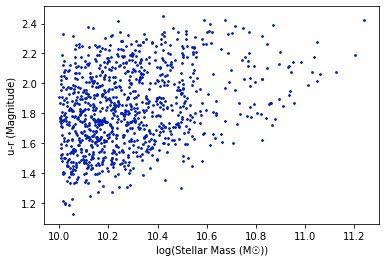

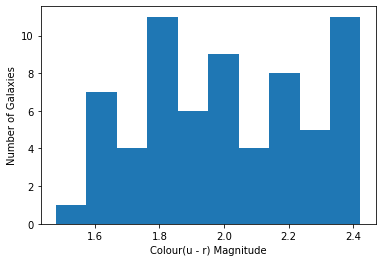

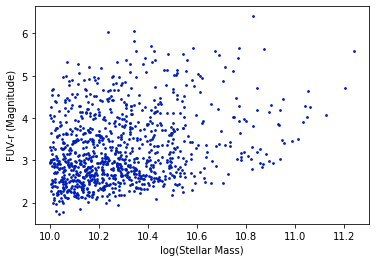

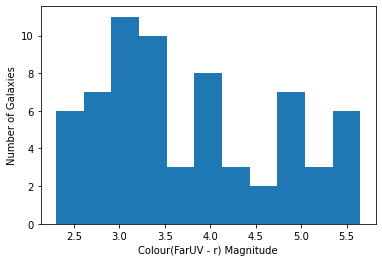

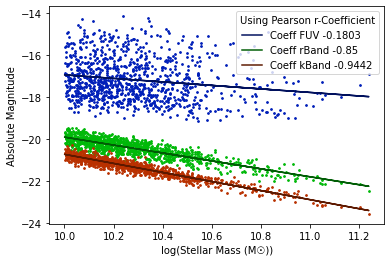

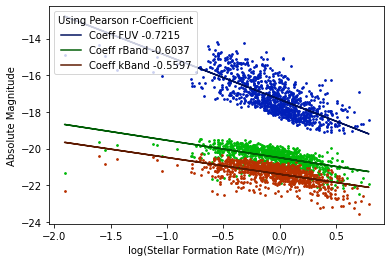

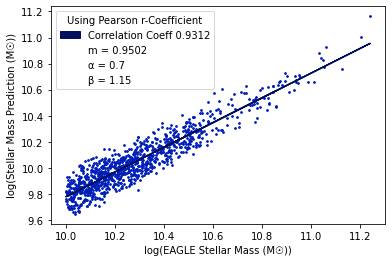

In [5]:
#LOG STAR MASS vs uSDSS-rSDSS

urSDSS = np.array(uBandSDSS) - np.array(rBandSDSS)
plt.figure(0)
plt.scatter(logSM, urSDSS, s=3, c="#001FB9")
plt.xlabel("log(Stellar Mass (M☉))")
plt.ylabel("u-r (Magnitude)")
plt.show()

plt.figure(1)
plt.hist(urSDSS[boolArr], 10)
plt.xlabel("Colour(u - r) Magnitude")
plt.ylabel("Number of Galaxies")
plt.show()

#LOG STAR MASS vs GALAX FUV-rSDSS

FUVr = np.array(galFUV) - np.array(rBandSDSS)
plt.figure(3)
plt.scatter(logSM, FUVr, s=3, c="#001FB9")
plt.xlabel("log(Stellar Mass)")
plt.ylabel("FUV-r (Magnitude)")
plt.show()

plt.figure(4)
plt.hist(FUVr[boolArr], 11)
plt.xlabel("Colour(FarUV - r) Magnitude")
plt.ylabel("Number of Galaxies")
plt.show()

#LOG STAR MASS vs FUV
#LOG STAR MASS vs rSDSS
#LOG STAR MASS vs kUKIDSS
#OPTIMIZING FIT + CORRCOEF

corr1 = np.corrcoef(logSM.T, galFUV.T)[1, 0]
vstack1 = np.vstack([logSM.T, np.ones(len(logSM))]).T
m1, c1 = np.linalg.lstsq(vstack1, galFUV, rcond=None)[0]
coeff1 = np.corrcoef(logSM.T, galFUV.T)
coeff1OUT = coeff1[0, 1]

corr2 = np.corrcoef(logSM.T, rBandSDSS.T)[1, 0]
vstack2 = np.vstack([logSM.T, np.ones(len(logSM))]).T
m2, c2 = np.linalg.lstsq(vstack2, rBandSDSS, rcond=None)[0]
coeff2 = np.corrcoef(logSM.T, rBandSDSS.T)
coeff2OUT = coeff2[0, 1]

corr3 = np.corrcoef(logSM.T, kBandUKIDSS.T)[1, 0]
vstack3 = np.vstack([logSM.T, np.ones(len(logSM))]).T
m3, c3 = np.linalg.lstsq(vstack3, kBandUKIDSS, rcond=None)[0]
coeff3 = np.corrcoef(logSM.T, kBandUKIDSS.T)
coeff3OUT = coeff3[0, 1]

plt.figure(5)
plt.scatter(logSM, galFUV, s=3, c="#001FB9")
plt.plot(logSM, logSM*m1+c1, c="#00105D", label='Coeff FUV '+str(round(coeff1OUT,4)))
plt.scatter(logSM, rBandSDSS, s=3, c="#00B909")
plt.plot(logSM, logSM*m2+c2, c="#005D05", label='Coeff rBand '+str(round(coeff2OUT,4)))
plt.scatter(logSM, kBandUKIDSS, s=3, c="#B93100")
plt.plot(logSM, logSM*m3+c3, c="#5D1900", label='Coeff kBand '+str(round(coeff3OUT,4)))
plt.legend(title="Using Pearson r-Coefficient")
plt.xlabel("log(Stellar Mass (M☉))")
plt.ylabel("Absolute Magnitude")
plt.show()

#LOG STAR FORMATION RATE vs FUV
#LOG STAR FORMATION RATE vs rSDSS
#LOG STAR FORMATION RATE vs kUKIDSS
#OPTIMIZING FIT + CORRCOEF

corr1 = np.corrcoef(logSFR.T, galFUV.T)[1, 0]
vstack1 = np.vstack([logSFR.T, np.ones(len(logSFR))]).T
m1, c1 = np.linalg.lstsq(vstack1, galFUV, rcond=None)[0]
coeff1 = np.corrcoef(logSFR.T, galFUV.T)
coeff1OUT = coeff1[0, 1]

corr2 = np.corrcoef(logSFR.T, rBandSDSS.T)[1, 0]
vstack2 = np.vstack([logSFR.T, np.ones(len(logSFR))]).T
m2, c2 = np.linalg.lstsq(vstack2, rBandSDSS, rcond=None)[0]
coeff2 = np.corrcoef(logSFR.T, rBandSDSS.T)
coeff2OUT = coeff2[0, 1]

corr3 = np.corrcoef(logSFR.T, kBandUKIDSS.T)[1, 0]
vstack3 = np.vstack([logSFR.T, np.ones(len(logSFR))]).T
m3, c3 = np.linalg.lstsq(vstack3, np.array(kBandUKIDSS), rcond=None)[0]
coeff3 = np.corrcoef(logSFR.T, kBandUKIDSS.T)
coeff3OUT = coeff3[0, 1]

plt.figure(6)
plt.scatter(logSFR, galFUV, s=3, c="#001FB9")
plt.plot(logSFR, logSFR*m1+c1, c="#00105D", label='Coeff FUV '+str(round(coeff1OUT,4)))
plt.scatter(logSFR, rBandSDSS, s=3, c="#00B909")
plt.plot(logSFR, logSFR*m2+c2, c="#005D05", label='Coeff rBand '+str(round(coeff2OUT,4)))
plt.scatter(logSFR, kBandUKIDSS, s=3, c="#B93100")
plt.plot(logSFR, logSFR*m3+c3, c="#5D1900", label='Coeff kBand '+str(round(coeff3OUT,4)))
plt.legend(title="Using Pearson r-Coefficient")
plt.xlabel("log(Stellar Formation Rate (M☉/Yr))")
plt.ylabel("Absolute Magnitude")

#PREDICTOR EQUATION
opticColour = np.array(np.array(gBandSDSS) - np.array(iBandSDSS)).flatten().T
broadBand = np.array(iBandSDSS).flatten().T
alpha = 0.7
beta = 1.15

predMass = -0.4*broadBand + alpha*(opticColour) + beta
realMass = np.array(np.log10(SM)).flatten().T

corr = np.corrcoef(realMass, predMass)[1,0]
vStack = np.vstack([realMass, np.ones(len(realMass))]).T
m, c = np.linalg.lstsq(vStack,np.array(predMass), rcond=None)[0]
coeff = np.corrcoef(realMass, predMass)
coeffOUT = coeff[0,1]

plt.figure(5)
plt.scatter(realMass,predMass,s=3,c="#001FB9")
plt.plot(realMass,realMass*m+c, c="#00105D")

line = Patch(color="#00105D" ,label = 'Correlation Coeff '+str(round(coeffOUT,4)))
mPatch = Patch(color='white', label="m = "+str(round(m,4)))
aPatch = Patch(color='white', label="α = "+str(alpha))
bPatch = Patch(color='white', label="β = "+str(beta))


plt.legend(title="Using Pearson r-Coefficient",handles=[line,mPatch,aPatch,bPatch])
plt.xlabel("log(EAGLE Stellar Mass (M☉))")
plt.ylabel("log(Stellar Mass Prediction (M☉))")

plt.show()

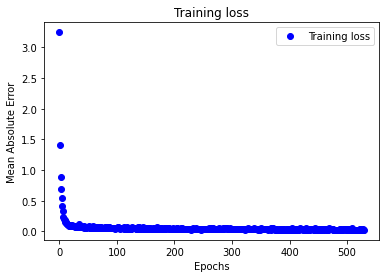

R^2 Score: 0.9596930780207297
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 22)                45        
_________________________________________________________________
dense (Dense)                (None, 64)                1472      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 98)                12642     
_________________________________________________________________
activation (Activation)      (None, 98)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 198       
Total params: 22,677
Trainable params: 22,632
Non-trainable params: 45
_____________________

In [6]:
dataTrain, dataTest = train_test_split(noiseless,test_size=0.2,train_size=0.8,random_state=42,shuffle=True)

columnList = ['GALEX_FUV','SDSS_u', 'SDSS_r', 'SDSS_i', 'SDSS_z', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K','Johnson_U','Johnson_I','IRAS_12','IRAS_25','IRAS_60','IRAC_I1','IRAC_I4','MIPS_70','MIPS_160','PACS_70','SPIRE_500','SCUBA2_450','SCUBA2_850']

trainIn = np.array(dataTrain[columnList])
trainOut = np.array(np.log10(dataTrain[['Stellar Mass [Msun]','Star Formation Rate [Msun/yr]']]))

testIn = np.array(dataTest[columnList])
testOut = np.array(np.log10(dataTest[['Stellar Mass [Msun]','Star Formation Rate [Msun/yr]']]))

model = trainModel(trainIn,trainOut)

eval = model.predict(testIn,verbose=0)

R2 = r2_score(testOut, eval, multioutput='variance_weighted')

print('R^2 Score:',R2)

model.summary()

In [7]:
columnList = ['GALEX_FUV','SDSS_u', 'SDSS_r', 'SDSS_i', 'SDSS_z', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K','Johnson_U','Johnson_I','IRAS_12','IRAS_25','IRAS_60','IRAC_I1','IRAC_I4','MIPS_70','MIPS_160','PACS_70','SPIRE_500','SCUBA2_450','SCUBA2_850']
eval = evaluateModel(data,columnList,output=True)

k = 1
0.9151036086604409
k = 2
0.796937287446017
k = 3
0.95236466168571
k = 4
0.9483792978833475
k = 5
0.9411621956962283
Mean: 0.9107894102743487


In [ ]:
columnList = ['GALEX_FUV','GALEX_NUV','SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z','UKIDSS_Z', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K',
                              'Johnson_U','Johnson_B','Johnson_V','Johnson_R','Johnson_I','Johnson_J','Johnson_M','WISE_W1','WISE_W2','WISE_W3','WISE_W4','IRAS_12',
                              'IRAS_25','IRAS_60','IRAS_100','IRAC_I1','IRAC_I2','IRAC_I3','IRAC_I4','MIPS_24','MIPS_70','MIPS_160','PACS_70','PACS_100','PACS_160',
                              'SPIRE_250','SPIRE_350','SPIRE_500','SCUBA2_450','SCUBA2_850']
length = len(np.transpose(data[columnList]))

for i in range(length):
  col= columnList.copy()
  na= col.pop(i)

  pred = evaluateModel(data,col)
  
  R2 = np.mean(pred)
  print('Without '+na+' :',R2)

In [ ]:
columnList = ['GALEX_FUV','SDSS_u', 'SDSS_r', 'SDSS_i', 'SDSS_z', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K','Johnson_U','Johnson_I','IRAS_12','IRAS_25','IRAS_60','IRAC_I1','IRAC_I4','MIPS_70','MIPS_160','PACS_70','SPIRE_500','SCUBA2_450','SCUBA2_850']
length = len(np.transpose(data[columnList]))

#learningRate = 0.0021
#numEpochs = 530
#b1 = 0.9
#b2 = 0.99
#rho = 1
#momentum = 0.005
#epsilon = 1e-08

for i in range(0,16,1):
  evaluations = evaluateModel(data,columnList,learningRate=(0.0018 + 0.00005*i))
  r2 = np.mean(evaluations)
  val =(0.0018 + 0.00005*i)

  print(val,'Learning Rate:',r2)

In [8]:
columnList = ['GALEX_FUV','SDSS_u', 'SDSS_r', 'SDSS_i', 'SDSS_z', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K','Johnson_U','Johnson_I','IRAS_12','IRAS_25','IRAS_60','IRAC_I1','IRAC_I4','MIPS_70','MIPS_160','PACS_70','SPIRE_500','SCUBA2_450','SCUBA2_850']

dataOut = np.array(np.log10(data[['Stellar Mass [Msun]','Star Formation Rate [Msun/yr]']]))
dataIn = np.array(data[columnList])

noiselessOut = np.array(np.log10(noiseless[['Stellar Mass [Msun]','Star Formation Rate [Msun/yr]']]))
noiselessIn = np.array(noiseless[columnList])

dataTest = model.predict(dataIn)
out1 = np.transpose(dataTest)

plotdataIn = noiselessIn
plotdataOut = noiselessOut 

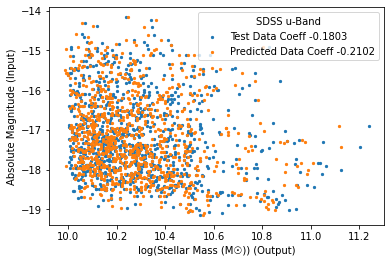

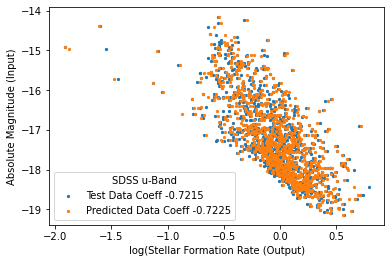

In [9]:
#SELECTING BAND AND PLOTTING ON AXES WITH REAL RESULTS
band = 0
if band == 0:
  title = "SDSS u-Band"
elif band == 1:
  title = "SDSS g-Band"
elif band == 2:
  title = "SDSS r-Band"
elif band == 3:
  title = "SDSS i-Band"
elif band == 4:
  title = "SDSS z-Band"

#PLOT BANDS AGAINST SM & SFR
corr1 = np.corrcoef(np.transpose(plotdataOut)[0], np.transpose(plotdataIn)[band])[0,1]
corr2 = np.corrcoef(out1[0], np.transpose(plotdataIn)[band])[0,1]
plt.scatter(np.transpose(plotdataOut)[0],np.transpose(plotdataIn)[band], label = 'Test Data Coeff '+str(round(corr1,4)), s=5)
plt.scatter(out1[0],np.transpose(plotdataIn)[band], label = 'Predicted Data Coeff '+str(round(corr2,4)), s=5)
plt.legend(title=title)
plt.xlabel("log(Stellar Mass (M☉)) (Output)")
plt.ylabel("Absolute Magnitude (Input)")
plt.show()

corr1 = np.corrcoef(np.transpose(plotdataOut)[1], np.transpose(plotdataIn)[band])[0,1]
corr2 = np.corrcoef(out1[1], np.transpose(plotdataIn)[band])[0,1]
plt.scatter(np.transpose(plotdataOut)[1],np.transpose(plotdataIn)[band],label = 'Test Data Coeff '+str(round(corr1,4)), s=5)
plt.scatter(out1[1],np.transpose(plotdataIn)[band], label = 'Predicted Data Coeff '+str(round(corr2,4)), s=5)
plt.legend(title=title)
plt.xlabel("log(Stellar Formation Rate (Output)")
plt.ylabel("Absolute Magnitude (Input)")
plt.show()

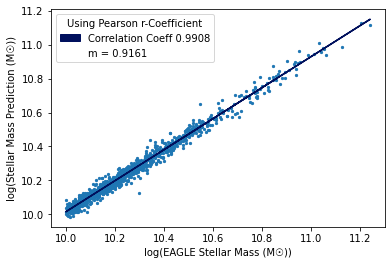

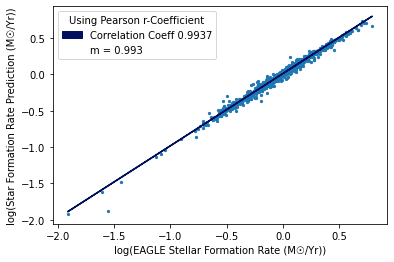

In [10]:
#PLOT COMPARISON OF PREDICTIONS AGAINST DATA
corr = np.corrcoef(np.transpose(plotdataOut)[0], out1[0])[0,1]
vStack = np.vstack([np.transpose(plotdataOut)[0], np.ones(len(np.transpose(plotdataOut)[0]))]).T
m, c = np.linalg.lstsq(vStack,np.array(out1[0]),rcond=None)[0]

linePatch = Patch(color="#00105D", label = 'Correlation Coeff '+str(round(corr,4)))
mPatch = Patch(color='white', label="m = "+str(round(m,4)))

plt.scatter(np.transpose(plotdataOut)[0], out1[0], s=5)
plt.plot(np.transpose(plotdataOut)[0], np.transpose(plotdataOut)[0]*m+c, c="#00105D")
plt.legend(title="Using Pearson r-Coefficient",handles=[linePatch, mPatch])
plt.xlabel("log(EAGLE Stellar Mass (M☉))")
plt.ylabel("log(Stellar Mass Prediction (M☉))")
plt.show()

corr = np.corrcoef(np.transpose(plotdataOut)[1], out1[1])[0,1]
vStack = np.vstack([np.transpose(plotdataOut)[1], np.ones(len(np.transpose(plotdataOut)[1]))]).T
m, c = np.linalg.lstsq(vStack,np.array(out1[1]),rcond=None)[0]

linePatch = Patch(color="#00105D", label = 'Correlation Coeff '+str(round(corr,4)))
mPatch = Patch(color='white', label="m = "+str(round(m,4)))

plt.scatter(np.transpose(plotdataOut)[1], out1[1],s=5)
plt.plot(np.transpose(plotdataOut)[1], np.transpose(dataOut)[1]*m+c, c="#00105D")
plt.legend(title="Using Pearson r-Coefficient",handles=[linePatch, mPatch])
plt.xlabel("log(EAGLE Stellar Formation Rate (M☉/Yr))")
plt.ylabel("log(Star Formation Rate Prediction (M☉/Yr))")
plt.show()